# **Test Ground for EWC Calculations**

## **Import libraries**

In [1]:
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.autograd as autograd

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from dcgan.components.generator import Generator
from dcgan.components.discriminator import Discriminator

# For working with Notebooks
from IPython.display import clear_output

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## **Define EWC-related class and functions**

In [44]:
class EWC:
    """
    Class for performing Elastic Weight Consolidation
    Reference link:
        https://discuss.pytorch.org/t/implementation-of-elastic-weight-consolidation-fisher-information-matrix/9309/3 
    """

    def __init__(self, model_anchor):
        self._model_anchor = model_anchor
        self._params_anchor = {n: p for n, p in model_anchor.named_parameters()}
        self._fishers, self._mean_fishers = None, None


    def _calc_fisher(self, likelihood, nsample=1):
        # TODO: Process unused params case
        grads = autograd.grad(likelihood, self._model_anchor.parameters())
        _fishers = [(g**2)/nsample for g in grads]

        param_names = [name for name, _ in self._model_anchor.named_parameters()]
        fs_dict = {n: f for n, f in zip(param_names, _fishers)}

        return fs_dict
    

    def set_fisher(self, likelihood, nsample=1):
        self._fishers = self._calc_fisher(likelihood, nsample=nsample)


    def get_fisher(self): return self._fishers

    
    def calc_ewc(self, model, weight=5e8):
        params = {n: p for n, p in model.named_parameters()}

        ewc = 0
        for name in self._fishers:
            _ewc = self._fishers[name]*(params[name] - self._params_anchor[name])**2
            ewc += _ewc.sum()

        return weight*ewc


def loss_adapt(l_adv, ewc, model, weight=5e8):
    l_ewc = ewc.calc_ewc(model, weight=weight)
    return l_adv + l_ewc

## **Model configuration**

In [4]:
gen_model = Generator()
gen_model.load_state_dict(torch.load('models/epoch145_gen.pth'))
gen_model.to(device)

dis_model = Discriminator()
dis_model.load_state_dict(torch.load('models/epoch145_dis.pth'))
dis_model.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   

## **Set hyperparameters**

In [5]:
batch_size = 12
latent_size = 512
criterion = nn.BCELoss()

## **Adaptation test**

### **Additional functions**

In [27]:
def make_image(file_name, generator, folderpath="plts", examples=25, dim=(5,5), figsize=(10,10)):
    noise= torch.randn(examples, latent_size).to(device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()
    plt.figure(figsize=figsize)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


    for i in range(generated_images.shape[0]):
        # Ghép các kênh màu lại thành một ảnh RGB
        plt.subplot(5, 5, i + 1)
        image = generated_images[i].permute(1,2,0)
        plt.imshow(image,interpolation='nearest',cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(folderpath, file_name))
    plt.close('all')
    

In [28]:
make_image("anime_gan_generated_image_145_preadapt.png", gen_model)

### **Prepare dataloader**

In [10]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),          
    #transforms.Normalize(mean=0.5, std=0.5)  
])

imgpath = "data/adapt_celebA"
dataset = ImageFolder(root=imgpath, transform=transform)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last= True)

print(len(dataloader))

28


### **Load to-be-adapted Generator**

In [11]:
adapt_generator = Generator()
adapt_generator.load_state_dict(torch.load('models/epoch145_gen.pth'))
adapt_generator.to(device)

optimizer_g = optim.Adam(adapt_generator.parameters(), lr=0.0006, betas=(0.5, 0.999))

### **Compute Fisher information (DO ONLY ONCE BEFORE ADAPTATION)**

tensor(5.2464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


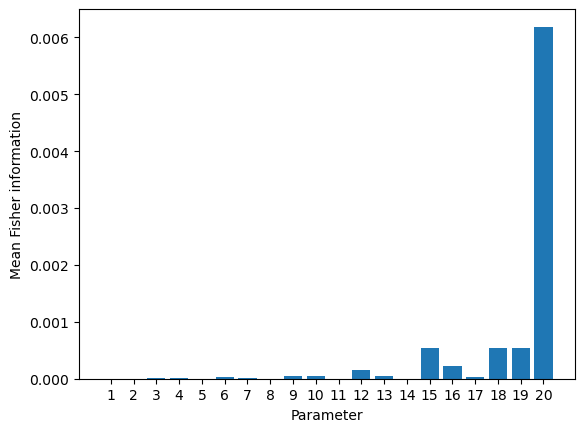

>>> l_adv tensor(5.2464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
>>> l_adapt tensor(5.2464, device='cuda:0', grad_fn=<AddBackward0>)


In [42]:
ewc = EWC(gen_model)

# Generate sample input and output
noise = torch.randn(300, latent_size).to(device)
output_d = dis_model(gen_model(noise)).view(-1)
real_label = torch.full((300, ), 0.99, dtype=torch.float).to(device)

# Error between Discriminator output and actual label
likelihood = criterion(output_d, real_label)
print(likelihood)

# Compute Fisher information for each parameter
ewc.set_fisher(likelihood, nsample=300)
fishers = ewc.get_fisher()

# Plot mean Fisher information
fisher_vals = [fishers[n].mean().detach().cpu() for n in fishers]
plt.bar(np.arange(len(fisher_vals)) + 1, fisher_vals)
plt.xticks(np.arange(len(fisher_vals)) + 1)
plt.xlabel("Parameter")
plt.ylabel("Mean Fisher information")
plt.show()

# Example value for adversarial loss
# NOTE: Will need to change formula in actual training
l_adv = criterion(output_d, real_label)

generator_new = deepcopy(gen_model)
l_adapt = loss_adapt(l_adv, ewc, generator_new)

print(">>> l_adv", l_adv)
print(">>> l_adapt", l_adapt)

### **Adapt loop**

In [26]:
g_history = []

real_lb = 0.99
fake_lb = 0

In [31]:
num_epochs = 20
regWeight = 10

for epoch in range(num_epochs):
    # Visualize the loss 
    print('Epoch : ',f'[{epoch}/{num_epochs}] ')
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(g_history) + 1), g_history, 'b', label='Generator Loss')
    plt.title('Generator and Discriminator Loss During Adaptation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    avg_loss_d = 0 
    avg_loss_g = 0
    for i, data in enumerate(tqdm(dataloader)):
        
        real_data = data[0].to(device)
        label = torch.full((batch_size, ), real_lb, dtype=torch.float).to(device)

        #-- Train Generator

        # Reset gradients
        adapt_generator.zero_grad()

        # Generate fake data + classification of Discriminator
        noise = torch.randn(batch_size, latent_size).to(device)
        fake_data = adapt_generator(noise)
        output = dis_model(fake_data).view(-1)

        label.fill_(real_lb)

        # TODO: Change loss function?
        loss_G_adv = criterion(output, label)
        
        # Compute L_adapt = L_adv + EWC
        loss_G = loss_adapt(loss_G_adv, ewc, adapt_generator, weight=regWeight)

        avg_loss_g += loss_G

        # Optimize step
        loss_G.backward()
        optimizer_g.step()

    avg_loss_g /= len(dataloader)
    g_history.append(avg_loss_g.detach().cpu().numpy())

    if epoch != num_epochs:
        clear_output()

    print(f'Loss_G: {avg_loss_g.item():.4f}')
    
    # Checkpoint
    if (epoch % 5 == 0):
        plt_save_path = f"gan_train_{epoch}.png"
        make_image(plt_save_path, adapt_generator)
        torch.save(adapt_generator.state_dict(), 'models/generator_adapt_epoch%d.pth' %epoch)
        

Loss_G: 0.0586


tensor(6.0524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


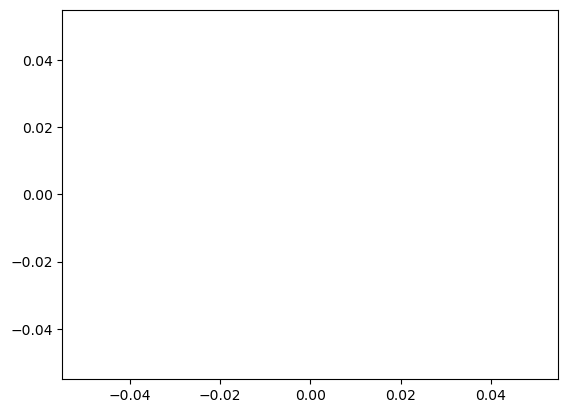

RuntimeError: The size of tensor a (0) must match the size of tensor b (512) at non-singleton dimension 1

In [45]:
ewc2 = EWC(adapt_generator)

# Generate sample input and output
noise = torch.randn(300, latent_size).to(device)
output_d = dis_model(gen_model(noise)).view(-1)
real_label = torch.full((300, ), 0.99, dtype=torch.float).to(device)

# Error between Discriminator output and actual label
likelihood = criterion(output_d, real_label)
print(likelihood)

# Compute Fisher information for each parameter
ewc2.set_fisher(likelihood, nsample=300)
fishers = ewc2.get_fisher()

fisher_vals = [fishers[n].mean().detach().cpu() for n in fishers]
plt.bar(np.arange(len(fisher_vals)) + 1, fisher_vals)
plt.show()

# Example value for adversarial loss
# NOTE: Will need to change formula in actual training
l_adv = criterion(output_d, real_label)

generator_new = deepcopy(gen_model)
l_adapt = loss_adapt(l_adv, ewc2, generator_new)

print(">>> l_adv", l_adv)
print(">>> l_adapt", l_adapt)

In [35]:
make_image("adapted_gan_generated.png", adapt_generator)